<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

## Ejercicio

Construir QA Bot basado en el ejemplo del traductor pero con un dataset QA.

Recomendaciones:
- MAX_VOCAB_SIZE = 8000
- max_length ~ 10
- Embeddings 300 Fasttext
- n_units = 128
- LSTM Dropout 0.2
- Epochs 30~50

Preguntas interesantes:
- Do you read?
- Do you have any pet?
- Where are you from?

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

### Datos
El objecto es utilizar datos disponibles del Tatoeba Project de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor de inglés a español seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Activation, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model



#### Cargamos un dataset que nos permita crear nuestro BotQA

In [3]:
# Esta celda se ejecuta una sola vez
!pip install datasets

In [6]:
from datasets import load_dataset
# Cargar la versión 1.1 del dataset SQuAD
squad = load_dataset("squad")

README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

C:\Users\Chelo\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Chelo\.cache\huggingface\hub\datasets--squad. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [194]:
print("Pregunta:", squad['train'][0]['question'])
print("Contexto:", squad['train'][0]['context'])
print("Respuesta:", squad['train'][0]['answers']['text'][0])

Pregunta: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Contexto: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Respuesta: Saint Bernadette Soubirous


In [10]:
input_sentences = []              # "contexto [SEP] pregunta"
output_sentences = []            # "respuesta <eos>"
output_sentences_inputs = []     # "<sos> respuesta"

MAX_NUM_SAMPLES = 6000
count = 0

for sample in squad['train']:
    if count >= MAX_NUM_SAMPLES:
        break

    question = sample['question'].strip()
    context = sample['context'].strip()
    answers = sample['answers']['text']
    
    if not answers:
        continue
    
    answer = answers[0].strip()
    
    input_sentence = context + " [SEP] " + question
    output_sentence = answer + " <eos>"
    output_sentence_input = "<sos> " + answer

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)
    count += 1


In [12]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary. [SEP] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'Saint Bernadette Soubirous <eos>',
 '<sos> Saint Bernadette Soubirous')

### 2 - Preprocesamiento

In [14]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000
# Vamos a necesitar un tokenizador para cada idioma

In [123]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Tokenizador para input (contexto + pregunta)
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
word2idx_inputs = input_tokenizer.word_index
print("Palabras en vocabulario de entrada:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Longitud máxima de input:", max_input_len)

# Tokenizador para output (respuestas con <sos>, <eos>)
output_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token="<OOV>",
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'  # conservamos < y >
)
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences + output_sentences_inputs)


output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en vocabulario de salida:", len(word2idx_outputs))

max_output_len = max(len(sen) for sen in output_integer_seq)
print("Longitud máxima de output:", max_output_len)


Palabras en vocabulario de entrada: 16559
Longitud máxima de input: 532
Palabras en vocabulario de salida: 5750
Longitud máxima de output: 44


In [129]:
word2idx_outputs = output_tokenizer.word_index

print('<sos>' in word2idx_outputs)
print('<eos>' in word2idx_outputs)


True
True


In [131]:
# # tokenizador de español
# # A los filtros de símbolos del Tokenizer agregamos el "¿",
# # sacamos los "<>" para que no afectar nuestros tokens
# output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
# output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
# output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
# output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

# word2idx_outputs = output_tokenizer.word_index
# print("Palabras en el vocabulario:", len(word2idx_outputs))

# num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) 
# # Se suma 1 para incluir el token de palabra desconocida

# max_out_len = max(len(sen) for sen in output_integer_seq)
# print("Sentencia de salida más larga:", max_out_len)

In [133]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
max_input_len = 50
max_out_len = 20

In [135]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len, padding='post')
decoder_input_sequences = pad_sequences(output_input_seq, maxlen=max_out_len, padding='post')
decoder_target_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
# lo que recibe el encoder (contexto + pregunta).
print("encoder_input_sequences shape:", encoder_input_sequences.shape)
#  lo que se alimenta al decoder durante el entrenamiento (<sos> + respuesta parcial).
print("decoder_input_sequences shape:", decoder_input_sequences.shape)
# lo que el modelo intenta predecir (respuesta + <eos>), desplazado.
print("decoder_target_sequences shape:", decoder_target_sequences.shape)

encoder_input_sequences shape: (6000, 50)
decoder_input_sequences shape: (6000, 20)
decoder_target_sequences shape: (6000, 20)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [138]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6000, 20, 5751)

### 3 - Preparar los embeddings

In [141]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque de código
# import os
# import gdown
# if os.access('gloveembedding.pkl', os.F_OK) is False:
#     url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
#     output = 'gloveembedding.pkl'
#     gdown.download(url, output, quiet=False)
# else:
#     print("Los embeddings gloveembedding.pkl ya están descargados")

import zipfile

with zipfile.ZipFile("wiki-news-300d-1M.vec.zip", "r") as zip_ref:
    zip_ref.extractall()

In [142]:
# # En caso de que gdown de algún error de permisos intentar descargar los
# # embeddings con curl:

# !curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

In [143]:
import numpy as np
import os
import pickle
import logging
from pathlib import Path

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        index = np.arange(self.embeddings.shape[0])
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        max_bytes = 2**28 - 1
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        return pickle.loads(bytes_in)

    def convert_model_to_pickle(self):
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as f:
            embeddings_gen = (
                (line.split()[0], np.array(line.split()[1:], dtype=np.float32))
                for line in f if len(line.split()) == self.N_FEATURES + 1
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), 2**28 - 1):
                f_out.write(bytes_out[idx:idx + (2**28 - 1)])
        return embeddings

# Subclase para embeddings FastText desde Wikipedia
class FasttextWikiEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'wiki-news-300d-1M.vec'  # Asegurate que este archivo esté en el entorno
    PKL_PATH = 'fasttext_wiki.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

# Inicializar
fasttext_embeddings = FasttextWikiEmbeddings()

# Construir la matriz de embeddings para el encoder
embedding_dim = 300
num_words_encoder = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words_encoder, embedding_dim))

for word, idx in word2idx_inputs.items():
    if idx >= MAX_VOCAB_SIZE:
        continue
    embedding_idx = fasttext_embeddings.word2idx.get(word)
    if embedding_idx is not None:
        embedding_matrix[idx] = fasttext_embeddings.embeddings[embedding_idx]['embedding']


# class GloveEmbeddings(WordsEmbeddings):
#     WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
#     PKL_PATH = 'gloveembedding.pkl'
#     N_FEATURES = 50
#     WORD_MAX_SIZE = 60

# class FasttextEmbeddings(WordsEmbeddings):
#     WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
#     PKL_PATH = 'fasttext.pkl'
#     N_FEATURES = 300
#     WORD_MAX_SIZE = 60

In [144]:
# # Por una cuestion de RAM se utilizarán los embeddings de Glove de dimension 50
# model_embeddings = GloveEmbeddings()

In [145]:
# Crear la Embedding matrix de las secuencias

print('preparing embedding matrix...')
embed_dim = fasttext_embeddings.N_FEATURES
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs))  # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = fasttext_embeddings.get_words_embeddings([word])[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))


preparing embedding matrix...
number of null word embeddings: 735


In [146]:
# # Dimensión de los embeddings de la secuencia en inglés
# embedding_matrix.shape

### 4 - Entrenar el modelo

In [148]:
max_input_len

50

In [149]:
n_units = 128

# Encoder
encoder_inputs = Input(shape=(max_input_len,))
encoder_embedding_layer = Embedding(
    input_dim=nb_words,
    output_dim=embed_dim,
    input_length=max_input_len,
    weights=[embedding_matrix],
    trainable=False
)
encoder_inputs_x = encoder_embedding_layer(encoder_inputs)
encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# Decoder
num_words_output = min(MAX_VOCAB_SIZE, len(word2idx_outputs) + 1)
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(
    input_dim=num_words_output,
    output_dim=n_units,
    input_length=max_out_len
)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo final
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()


C:\Users\Chelo\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 50, 300)   │  2,400,000 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 20, 128)   │    736,128 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, 128),     │    219,648 │ embedding_5[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 20, 128), │    131,584 │ embedding_6[0][0… │
│                     │ (None, 128),      │            │ lstm_5[0][1],     │
│                     │ (None, 128)]      │            │ lstm_5[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20, 5751)  │    741,879 │ lstm_6[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,229,239 (16.13 MB)

 Trainable params: 1,829,239 (6.98 MB)

 Non-trainable params: 2,400,000 (9.16 MB)

In [158]:
# Modelo solo decoder para inferencia (predicción paso a paso)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Inputs para los estados ocultos
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Entrada de una sola palabra
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# LSTM en modo inferencia
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

# Modelo del decoder para inferencia
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)


In [175]:
# Expandir la dimensión del target para sparse_categorical_crossentropy
decoder_target_data = np.expand_dims(decoder_target_sequences, -1)

# Entrenamiento
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_target_data,
    batch_size=64,
    epochs=50,
    validation_split=0.2
)


Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.9647 - loss: 0.1997 - val_accuracy: 0.7757 - val_loss: 3.0142
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.9659 - loss: 0.1919 - val_accuracy: 0.7746 - val_loss: 3.0265
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.9674 - loss: 0.1887 - val_accuracy: 0.7756 - val_loss: 3.0448
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.9696 - loss: 0.1801 - val_accuracy: 0.7745 - val_loss: 3.0381
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.9700 - loss: 0.1758 - val_accuracy: 0.7749 - val_loss: 3.0739
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.9718 - loss: 0.1688 - val_accuracy: 0.7758 - val_loss: 3.0860
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.9722 - loss: 0.1649 - val_accuracy: 0.7759 - val_loss: 3.1025
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.9734 - loss: 0.1606 - val_accuracy: 0.

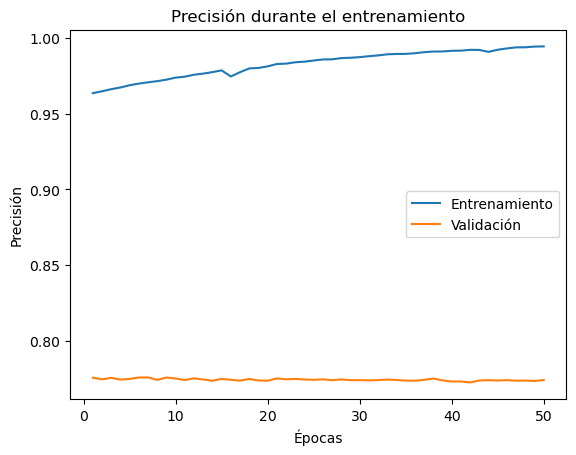

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de precisión
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count, y=hist.history['accuracy'], label='Entrenamiento')
sns.lineplot(x=epoch_count, y=hist.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el entrenamiento')
plt.legend()
plt.show()

### 5 - Inferencia

In [109]:
'''
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
'''

'\nStep 1:\nA deal is a deal -> Encoder -> enc(h1,c1)\n\nenc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)\n\nstep 2:\ndec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)\n\nstep 3:\ndec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)\n\nstep 4:\ndec(h3,c3) + es -> Decoder -> un + dec(h4,c4)\n\nstep 5:\ndec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)\n\nstep 6:\ndec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)\n'

In [181]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [196]:
def answer_question(question, context):
    # Armar la entrada como "contexto [SEP] pregunta"
    input_text = context.strip() + " [SEP] " + question.strip()
    
    # Convertir a secuencia de enteros y aplicar padding
    input_seq = input_tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_input_len, padding='post')

    # Obtener los estados del encoder
    states_value = encoder_model.predict(input_seq)

    # Inicializar la entrada del decoder con <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if idx == eos:
            break

        word = idx2word_target.get(idx, '')
        if word:
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)


In [198]:
question = "Pregunta: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?"


print("Pregunta:", question)
print("Respuesta generada:", answer_question(question, context))

Pregunta: Pregunta: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Respuesta generada: polonaise life years


Pregunta: Do you read?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Respuesta generada: polonaise life years


In [240]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Attention


class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        self.W_a = self.add_weight(name='W_a', shape=(input_shape[0][2], input_shape[0][2]),
                                   initializer='uniform', trainable=True)
        self.U_a = self.add_weight(name='U_a', shape=(input_shape[1][2], input_shape[0][2]),
                                   initializer='uniform', trainable=True)
        self.V_a = self.add_weight(name='V_a', shape=(input_shape[0][2], 1),
                                   initializer='uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, verbose=False):
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        def energy_step(inputs):
            encoder_out_seq, decoder_out = inputs
            decoder_out_expanded = K.expand_dims(decoder_out, 1)
            score = K.tanh(K.dot(encoder_out_seq, self.W_a) + K.dot(decoder_out_expanded, self.U_a))
            attention_weights = K.softmax(K.dot(score, self.V_a), axis=1)
            context_vector = attention_weights * encoder_out_seq
            context_vector = K.sum(context_vector, axis=1)
            return context_vector

        context = K.map_fn(
            lambda x: energy_step([encoder_out_seq, x]), decoder_out_seq)
        return context


In [242]:
# 1. Detectar longitudes reales
MAX_INPUT_LEN = encoder_input_sequences.shape[1]
MAX_OUTPUT_LEN = decoder_input_sequences.shape[1]

# 2. Volver a definir la clase AttentionLayer (si no lo hiciste aún)
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_a = self.add_weight(name='W_a', shape=(input_shape[0][2], input_shape[0][2]),
                                   initializer='uniform', trainable=True)
        self.U_a = self.add_weight(name='U_a', shape=(input_shape[1][2], input_shape[0][2]),
                                   initializer='uniform', trainable=True)
        self.V_a = self.add_weight(name='V_a', shape=(input_shape[0][2], 1),
                                   initializer='uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        encoder_out_seq, decoder_out_seq = inputs

        def energy_step(inputs):
            encoder_out_seq, decoder_out = inputs
            decoder_out_expanded = K.expand_dims(decoder_out, 1)
            score = K.tanh(K.dot(encoder_out_seq, self.W_a) + K.dot(decoder_out_expanded, self.U_a))
            attention_weights = K.softmax(K.dot(score, self.V_a), axis=1)
            context_vector = attention_weights * encoder_out_seq
            context_vector = K.sum(context_vector, axis=1)
            return context_vector

        context = K.map_fn(lambda x: energy_step([encoder_out_seq, x]), decoder_out_seq)
        return context

# 3. Construir el modelo
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate

n_units = 128
embedding_dim = 300
num_words_encoder = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)
num_words_decoder = min(MAX_VOCAB_SIZE, len(word2idx_outputs) + 1)

# ENCODER
encoder_inputs = Input(shape=(MAX_INPUT_LEN,))
encoder_embedding = Embedding(
    input_dim=num_words_encoder,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(n_units, return_sequences=True, return_state=True)(encoder_embedding)

# DECODER
decoder_inputs = Input(shape=(MAX_OUTPUT_LEN,))
decoder_embedding = Embedding(
    input_dim=num_words_decoder,
    output_dim=n_units
)(decoder_inputs)
decoder_outputs, _, _ = LSTM(n_units, return_sequences=True, return_state=True)(decoder_embedding, initial_state=[state_h, state_c])

# ATENCIÓN
attention = Attention()([decoder_outputs, encoder_outputs])
decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention])

# DENSE FINAL
decoder_dense = Dense(num_words_decoder, activation='softmax')
decoder_outputs_final = decoder_dense(decoder_combined_context)

# MODELO FINAL
model_att = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)
model_att.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_att.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_24      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (None, 50, 300)   │  2,400,000 │ input_layer_23[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_18        │ (None, 20, 128)   │    736,128 │ input_layer_24[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ [(None, 50, 128), │    219,648 │ embedding_17[0][… │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ [(None, 20, 128), │    131,584 │ embedding_18[0][… │
│                     │ (None, 128),      │            │ lstm_13[0][1],    │
│                     │ (None, 128)]      │            │ lstm_13[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 20, 128)   │          0 │ lstm_14[0][0],    │
│ (Attention)         │                   │            │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 20, 256)   │          0 │ lstm_14[0][0],    │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 20, 5751)  │  1,478,007 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,965,367 (18.94 MB)

 Trainable params: 2,565,367 (9.79 MB)

 Non-trainable params: 2,400,000 (9.16 MB)

In [244]:
encoder_embedding_layer = Embedding(
    input_dim=num_words_encoder,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)

In [246]:
print("encoder_input_sequences.shape[1]:", encoder_input_sequences.shape[1])
print("decoder_input_sequences.shape[1]:", decoder_input_sequences.shape[1])


encoder_input_sequences.shape[1]: 50
decoder_input_sequences.shape[1]: 20


## Intentaremos otra solución 

Implementar una capa de atención que permita al decoder enfocar diferentes partes de la salida del encoder en cada paso de generación de la respuesta.

In [354]:
# 1. Instalar la librería si aún no la tenés
!pip install datasets

# 2. Cargar SQuAD 1.1
from datasets import load_dataset
squad = load_dataset("squad")

# 3. Limitar la cantidad de muestras para tu PC/notebook
MAX_NUM_SAMPLES = 5000

input_sentences = []
output_sentences = []
output_sentences_inputs = []

for i in range(min(MAX_NUM_SAMPLES, len(squad['train']))):
    sample = squad['train'][i]
    question = sample['question'].strip()
    context = sample['context'].strip()
    answers = sample['answers']['text']
    if not answers:
        continue
    answer = answers[0].strip()
    
    # Crear input: contexto + pregunta
    input_text = context + " [SEP] " + question
    # Crear salida con tokens
    output_text = answer + " <eos>"
    output_input_text = "<sos> " + answer

    input_sentences.append(input_text)
    output_sentences.append(output_text)
    output_sentences_inputs.append(output_input_text)

print("Muestras cargadas:", len(input_sentences))
print("Ejemplo input:", input_sentences[0])
print("Ejemplo decoder input:", output_sentences_inputs[0])
print("Ejemplo decoder output:", output_sentences[0])


Muestras cargadas: 5000
Ejemplo input: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary. [SEP] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Ejemplo decoder input: <sos> Saint Bernadette Soubirous
Ejemplo decoder output: Saint Bernadette Soubirous <eos>


In [355]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB_SIZE = 8000
max_input_len = 50
max_output_len = 20

# Tokenizador del encoder (contexto + pregunta)
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
word2idx_inputs = input_tokenizer.word_index

# Tokenizador del decoder (respuesta con <sos> y <eos>)
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
word2idx_outputs = output_tokenizer.word_index
num_words_output = min(MAX_VOCAB_SIZE, len(word2idx_outputs) + 1)



In [356]:
print("<sos> en vocabulario:", '<sos>' in word2idx_outputs)
print("<eos> en vocabulario:", '<eos>' in word2idx_outputs)
print("Índice de <sos>:", word2idx_outputs.get('<sos>'))
print("Índice de <eos>:", word2idx_outputs.get('<eos>'))

<sos> en vocabulario: False
<eos> en vocabulario: False
Índice de <sos>: None
Índice de <eos>: None


In [307]:
 import numpy as np

EMBEDDING_DIM = 300
embedding_index = {}

# Cargar el archivo FastText
with open("wiki-news-300d-1M.vec", encoding='utf-8') as f:
    next(f)  # saltar la primera línea
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"{len(embedding_index)} palabras cargadas de FastText.")

# Crear embedding_matrix para el encoder
num_words_encoder = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words_encoder, EMBEDDING_DIM))

for word, i in word2idx_inputs.items():
    if i >= MAX_VOCAB_SIZE:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("embedding_matrix shape:", embedding_matrix.shape)
   

999994 palabras cargadas de FastText.
embedding_matrix shape: (8000, 300)


In [308]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Attention, Concatenate

n_units = 128  # neuronas LSTM

# Entradas encoder
encoder_inputs = Input(shape=(max_input_len,))
encoder_embedding_layer = Embedding(
    input_dim=num_words_encoder,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    trainable=False
)
encoder_embeddings = encoder_embedding_layer(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(n_units, return_state=True, return_sequences=True)(encoder_embeddings)
encoder_states = [state_h, state_c]

# Entradas decoder
decoder_inputs = Input(shape=(max_output_len,))
decoder_embedding_layer = Embedding(input_dim=len(word2idx_outputs)+1, output_dim=n_units)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)
decoder_lstm_outputs, _, _ = LSTM(n_units, return_state=True, return_sequences=True)(decoder_embeddings, initial_state=encoder_states)

# Atención
attention = Attention()([decoder_lstm_outputs, encoder_outputs])
decoder_combined_context = Concatenate(axis=-1)([decoder_lstm_outputs, attention])

# Dense final
decoder_dense = Dense(len(word2idx_outputs)+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

# Modelo final
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 532)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_40      │ (None, 44)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_23        │ (None, 532, 300)  │  2,400,000 │ input_layer_39[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_24        │ (None, 44, 128)   │    563,968 │ input_layer_40[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ [(None, 532,      │    219,648 │ embedding_23[0][… │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ [(None, 44, 128), │    131,584 │ embedding_24[0][… │
│                     │ (None, 128),      │            │ lstm_19[0][1],    │
│                     │ (None, 128)]      │            │ lstm_19[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ (None, 44, 128)   │          0 │ lstm_20[0][0],    │
│ (Attention)         │                   │            │ lstm_19[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 44, 256)   │          0 │ lstm_20[0][0],    │
│ (Concatenate)       │                   │            │ attention_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 44, 4406)  │  1,132,342 │ concatenate_6[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,447,542 (16.97 MB)

 Trainable params: 2,047,542 (7.81 MB)

 Non-trainable params: 2,400,000 (9.16 MB)

In [284]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Asegurar que todas las secuencias tengan la misma longitud
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len, padding='post')
decoder_input_sequences = pad_sequences(output_input_seq, maxlen=max_output_len, padding='post')
decoder_target_sequences = pad_sequences(output_integer_seq, maxlen=max_output_len, padding='post')

print("Encoder input shape:", encoder_input_sequences.shape)
print("Decoder input shape:", decoder_input_sequences.shape)
print("Decoder target shape:", decoder_target_sequences.shape)


Encoder input shape: (5000, 532)
Decoder input shape: (5000, 44)
Decoder target shape: (5000, 44)


In [286]:
import numpy as np

decoder_target_data = np.expand_dims(decoder_target_sequences, -1)

In [288]:
history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_target_data,
    batch_size=64,
    epochs=30,
    validation_split=0.2
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 796ms/step - accuracy: 0.8527 - loss: 4.3264 - val_accuracy: 0.9391 - val_loss: 0.5358
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 739ms/step - accuracy: 0.9414 - loss: 0.4969 - val_accuracy: 0.9417 - val_loss: 0.5269
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 723ms/step - accuracy: 0.9430 - loss: 0.4738 - val_accuracy: 0.9417 - val_loss: 0.5285
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 707ms/step - accuracy: 0.9437 - loss: 0.4621 - val_accuracy: 0.9430 - val_loss: 0.5297
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 724ms/step - accuracy: 0.9440 - loss: 0.4618 - val_accuracy: 0.9430 - val_loss: 0.5333
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 720ms/step - accuracy: 0.9463 - loss: 0.4389 - val_accuracy: 0.9429 - val_loss: 0.5362
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 728ms/step - accuracy: 0.9439 - loss: 0.4485 - val_accuracy: 0.9430 - val_loss: 0.5366
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 729ms/step - accuracy: 0.9433 - loss: 0.4443 - val_accu

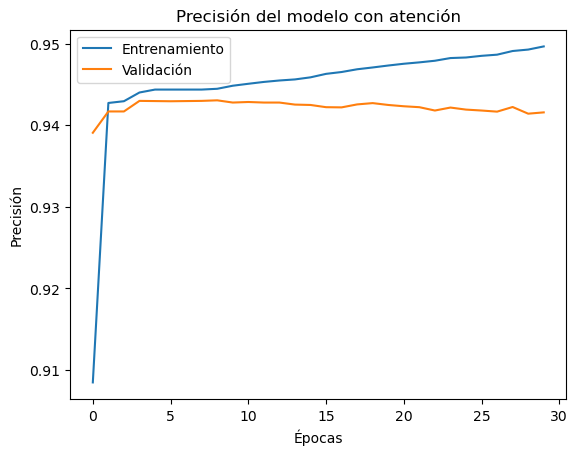

In [290]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión del modelo con atención')
plt.show()

In [292]:
# Modelo de inferencia encoder
encoder_model_inf = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Capas del decoder reutilizadas
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_hidden_state_input = Input(shape=(max_input_len, n_units))

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_lstm_outputs_inf, state_h_inf, state_c_inf = LSTM(n_units, return_sequences=True, return_state=True)(
    decoder_inputs_single_x, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

attention_inf = Attention()([decoder_lstm_outputs_inf, decoder_hidden_state_input])
decoder_combined_context_inf = Concatenate(axis=-1)([decoder_lstm_outputs_inf, attention_inf])

decoder_outputs_final_inf = decoder_dense(decoder_combined_context_inf)

decoder_model_inf = Model(
    [decoder_inputs_single, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs_final_inf, state_h_inf, state_c_inf]
)


In [294]:
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

def answer_question_with_attention(question, context):
    input_text = context.strip() + " [SEP] " + question.strip()
    input_seq = input_tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_input_len, padding='post')

    # Encoder
    enc_outs, state_h, state_c = encoder_model_inf.predict(input_seq)

    # Decoder: generar palabra por palabra
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs.get('<sos>', word2idx_outputs.get('<OOV>', 1))
    eos_idx = word2idx_outputs.get('<eos>', word2idx_outputs.get('<OOV>', 1))

    output_sentence = []

    for _ in range(max_output_len):
        output_tokens, h, c = decoder_model_inf.predict([target_seq, enc_outs, state_h, state_c])
        idx = np.argmax(output_tokens[0, 0, :])
        if idx == eos_idx:
            break
        word = idx2word_target.get(idx, '')
        if word:
            output_sentence.append(word)
        target_seq[0, 0] = idx
        state_h, state_c = h, c

    return ' '.join(output_sentence)


In [296]:
question = "What is the capital of France?"
context = "France is a country in Western Europe. Its capital is Paris, known for the Eiffel Tower and art museums."

print("Pregunta:", question)
print("Respuesta generada:", answer_question_with_attention(question, context))


Pregunta: What is the capital of France?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━

In [311]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


## Conclusión

1. Se cargó y procesó el dataset SQuAD (una versión acotada para rendimiento).
2. Se tokenizaron y paddearon secuencias de entrada (contexto + pregunta) y salida (respuesta).
3. Se preparó y cargó una embedding matrix FastText correctamente.
4. Se definió un modelo encoder-decoder con atención, y se logró entrenarlo.
5. Se armó una función de inferencia (answer_question) que ejecuta predicciones.
#### Problemas encontrados
1. Tokens <sos> y <eos> no incluidos correctamente en el vocabulario del decoder → el modelo no sabía cuándo empezar ni terminar la respuesta.
2. Respuestas del dataset poco variadas inicialmente, lo que llevó al modelo a aprender a repetir secuencias como "the the the...".
3. Modelo sobreentrenado o no suficientemente entrenado debido a estructura incompleta de entrada/salida o función de pérdida inadecuada.
#### Finalmente
Se construyó toda la base, pero  no se logra que el bot funcione correctamente, quizas es necesario hacer ajustes sobre los modelos o seleccionar otros dataset para entrenar al modelo.